In [9]:
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np
import operator
import pandas as pd
import pickle
import random
import scipy
from sklearn.metrics.pairwise import linear_kernel
from sklearn.neighbors import NearestNeighbors


import src.knntools as knntools
import src.postprocess as postprocess
import src.preprocess as preprocess
import src.tfidftools as tfidftools
import src.tools as tools
import src.recencytools as recency
import src.scoring as scoring

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
path_to_data = 'data/'

training = pd.read_csv(path_to_data + 'training_set.csv', sep=',', header=0)

training_info = pd.read_csv(
    path_to_data + 'training_info.csv', sep=',', parse_dates=True, header=0)

test = pd.read_csv(path_to_data + 'test_set.csv', sep=',', header=0)

test_info = pd.read_csv(path_to_data + 'test_info.csv',
                        sep=',', parse_dates=True, header=0)
path_to_results = 'results/'

In [11]:
train_info, train_email_ids_per_sender, val_info, val_email_ids_per_sender = scoring.get_train_val(training, training_info, train_frac=0.95)

Processing training !
Processing val !


In [12]:
token_dict = preprocess.body_dict_from_panda(train_info)

## Compute tfidf representation

In [13]:
tfidf_model, tfidf_matrix, tfidf_mids = tfidftools.get_tfidf(token_dict, 0.001, 0.10)

In [14]:
print(tfidf_matrix.shape)

(41432, 8240)


The tfidf vectors are of size 8240.

In [19]:
nb_neighbors_list = [40, 50, 70, 100]


In [20]:
nb_recipients = 10
scores = []

for nb_neighbors in nb_neighbors_list:
    mid_recipient_scores = knntools.compute_similarity_scores(tfidf_model, tfidf_matrix,
                                  tfidf_mids, train_info, val_info, nb_similars=nb_neighbors)
    knn_predictions = knntools.similar_dic_to_standard(mid_recipient_scores, nb_recipients)
    current_score = scoring.compute_prediction_mad(knn_predictions, val_info)
    path_to_ranks = 'ranks_val/knn-k-{nb_neighbors}-rec-{nb_recip}'.format(nb_neighbors=nb_neighbors,
                                                                     nb_recip=nb_recipients)
    with open(path_to_ranks, 'wb') as infile:
              pickle.dump(knn_predictions, infile)
    scores.append(current_score)
    print('score for {nb_neighbor} is {score}'.format(nb_neighbor=nb_neighbors, score=current_score))

score for 40 is 0.2361762995228149
score for 50 is 0.23958102752198404
score for 70 is 0.23964224661114467
score for 100 is 0.2329420962222238


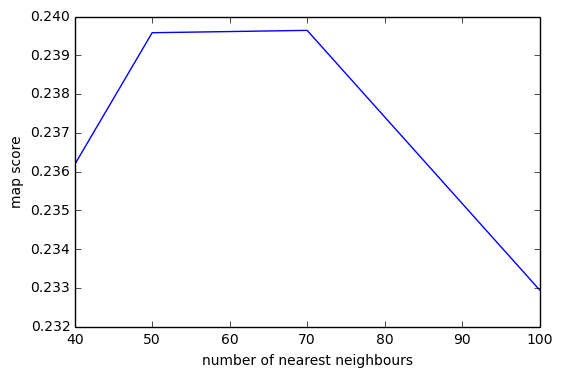

In [21]:
plt.plot(nb_neighbors_list, scores)
plt.xlabel('number of nearest neighbours')
plt.ylabel('map score')
plt.show()

### Compute best knn model and save to files

In [48]:
best_neighbor_nb = 50
mid_recipient_scores = knntools.compute_similarity_scores(tfidf_model, tfidf_matrix,
                                  tfidf_mids, train_info, val_info, nb_similars=best_neighbor_nb)


In [49]:
knn_predictions = knntools.similar_dic_to_standard(mid_recipient_scores, keep_all=True)
best_score = scoring.compute_prediction_mad(knn_predictions, val_info)
print(best_score)

0.234852695217


In [47]:
path_to_ranks = 'ranks_val/knn-k-{nb_neighbors}-rec-all'.format(nb_neighbors=best_neighbor_nb)
with open(path_to_ranks, 'wb') as infile:
          pickle.dump(knn_predictions, infile)